This code analyses data that Jenny acquired. She ran 3 flies, which got a 5 min trial each. The trial started with a blue bar in closed-loop with the animal, and some time into the trial, the panels were turned off and the fly was left in the darkness. A few minutes after that, the panels were turned on and the animal was once again faced with a blue bar in closed-loop. While the animals were undergoing this behavioral paradigm, she imaged their EPG cells in the PB, which expressed GCaMP6f or GCaMP7f. She used 60D05-Gal4 flies.
We are interested in seeing the differences in the EPG bump between what we will define as 'certain' and 'uncertain' states (reliable landmark in closed-loop, and darkness, respectively).

In [1]:
#Import all the modules we will be using

import os #import module to view and manipulate directories
import scipy.io as sio #import module to open matlab files
import matplotlib.pyplot as plt #import the plotting module
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy.stats import circstd, pearsonr
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [3]:
#Load data for single analyses
mainDir = os.getcwd()[:-7]


In [16]:
files = os.listdir(mainDir + '\data')  #get the list of folders in it
folders = []
for file in range(len(files)):
    if os.path.isdir(mainDir + "\data\\" + files[file]):
        folders.append(files[file])
flyNum = len(folders) #determine fly number

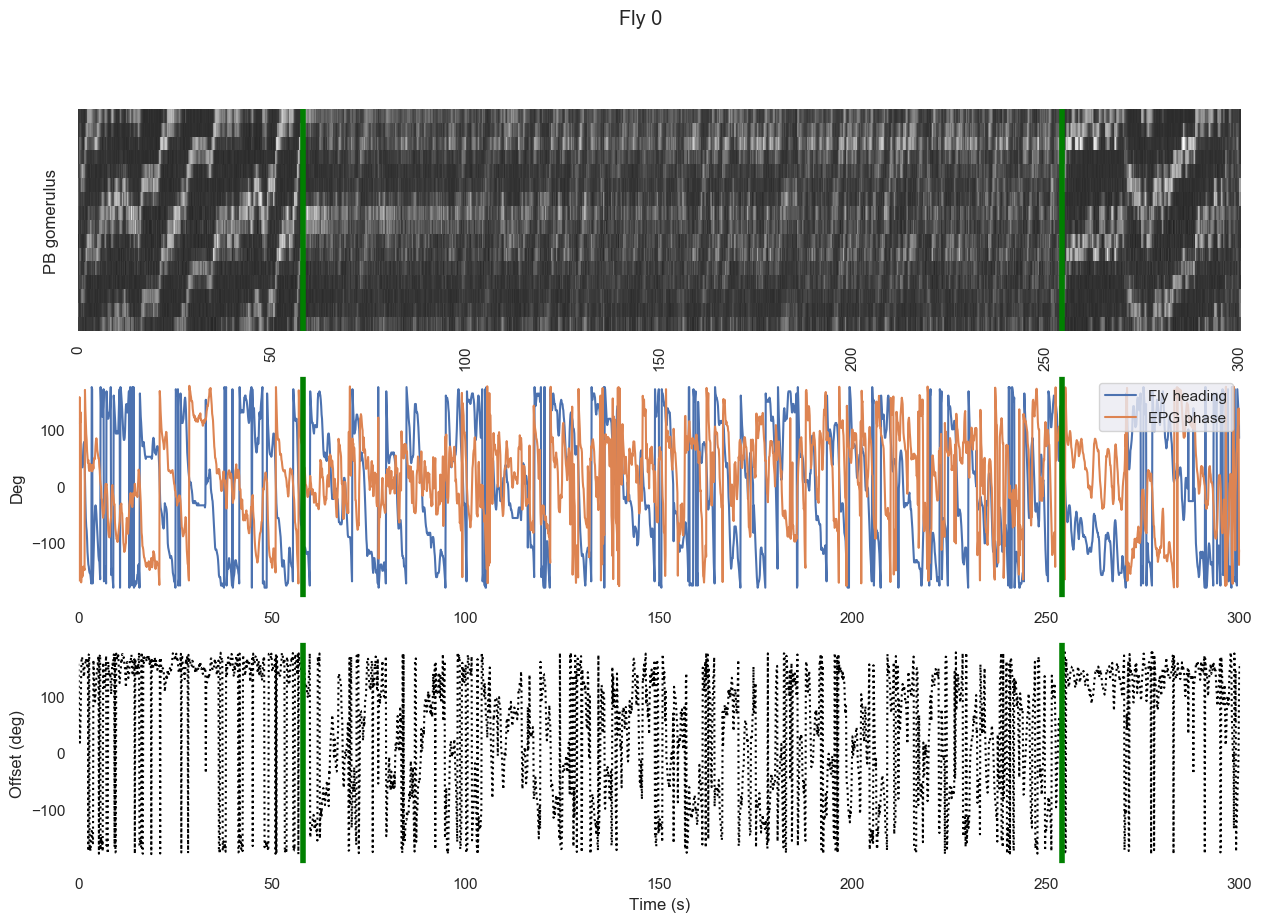

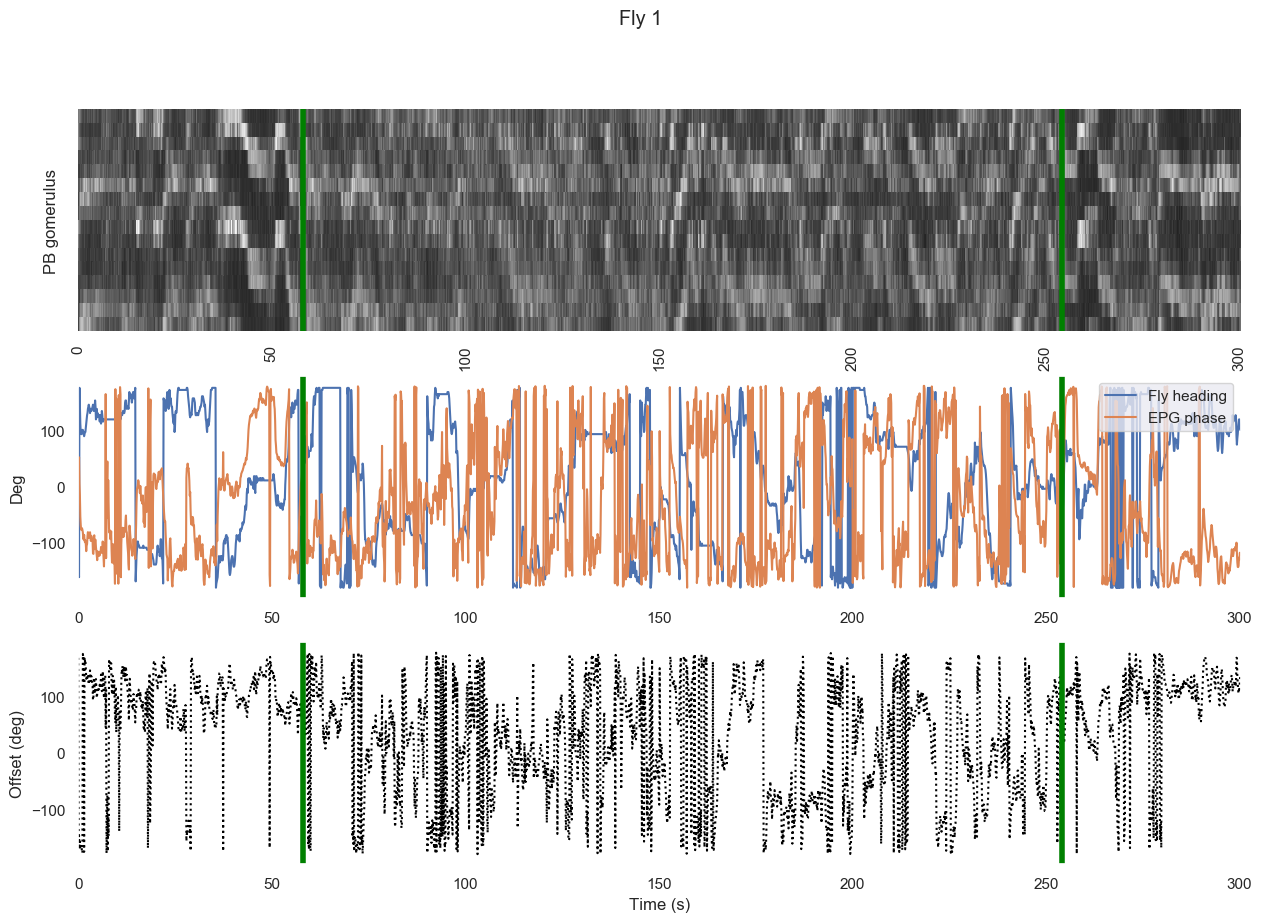

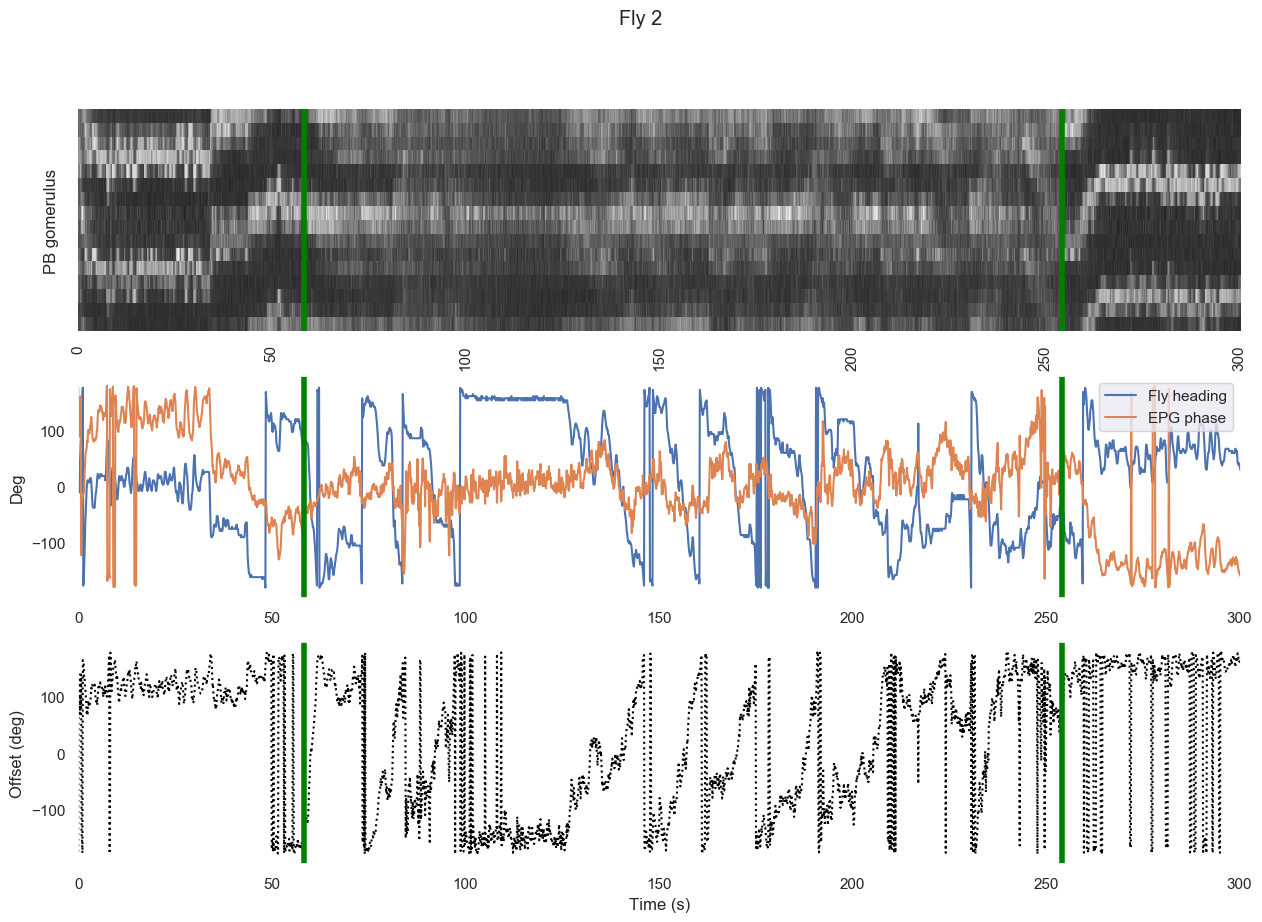

In [19]:
#For each fly, plot the heatmap for the neural data, the fly heading and EPG phase, and the offset

for fly in range(flyNum): #for each of the folders
    os.chdir(mainDir + '\data\\' + folders[fly] + '\\dark trial') #move inside of the folder, inside the dark trial folder
    file = os.listdir() #get the file names
    data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
    flyData = data['data'] #store only the data from that dictionnary object into a new object called flyData. This is now a numpy.ndarray
    
    #Find where the panels are turned off and then on
    panelOFF = np.array(np.where(flyData[0,0].fr_y_ds == 1)) #I don't understand why panelOFF has 2 rows. The second one just has zeros. Is there a way to avoid it?
    StartDark = panelOFF[0,0]
    EndDark = panelOFF[0,-1]
    
    #plot heatmap of neural activity
    dff_matrix = flyData[0,0].dff_matrix
    my_cmap = sns.dark_palette("white", as_cmap=True)
    fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)
    fig.suptitle('Fly ' + str(fly))
    g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    g.set_ylabel('PB gomerulus')
    ax1.axvline(x=StartDark, color='green', lw = 4)
    ax1.axvline(x=EndDark, color='green', lw = 4)
    
    
    ax2 = plt.subplot(312, sharex=ax1)
    #ax2.plot(flyData[0,0].time,np.transpose(np.rad2deg(flyData[0,0].panel_angle)))   
    #ax2.plot(flyData[0,0].time,np.transpose(np.rad2deg(flyData[0,0].phase)))
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].panel_angle)))   
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].phase)))   
    ax2.set(xticklabels=[])
    ax2.set(ylabel='Deg')
    ax2.set_facecolor('white')
    #ax2.axvline(x=flyData[0,0].time[StartDark], color='green', lw = 4)
    #ax2.axvline(x=flyData[0,0].time[EndDark], color='green', lw = 4) 
    ax2.axvline(x=StartDark, color='green', lw = 4)
    ax2.axvline(x=EndDark, color='green', lw = 4) 
    ax2.legend(('Fly heading', 'EPG phase'),loc='upper right')
    
    
    ax3 = plt.subplot(313, sharex = ax1)
    #ax3.plot(flyData[0,0].time,np.transpose((np.rad2deg(flyData[0,0].offset))),color ='black',linestyle=':')
    ax3.plot(np.transpose((np.rad2deg(flyData[0,0].offset))),color ='black',linestyle=':')    
    ax3.set_facecolor('white')
    #ax3.axvline(x=flyData[0,0].time[StartDark], color='green', lw = 4)
    #ax3.axvline(x=flyData[0,0].time[EndDark], color='green', lw = 4)
    ax3.axvline(x=StartDark, color='green', lw = 4)
    ax3.axvline(x=EndDark, color='green', lw = 4) 
    plt.ylabel('Offset (deg)')
    plt.xlabel('Time (s)')
    x_locations = np.arange(0, len(flyData[0,0].time), 458)
    ax3.set_xticks(x_locations)
    ax3.set_xticklabels(('0','50','100','150','200','250','300'))
    plt.savefig(mainDir + "\plots\IndividualPlotsFly"  + str(fly) + ".png", dpi=150)

    #add axes lines
    #add colorbar without shrinking the heatmap

     

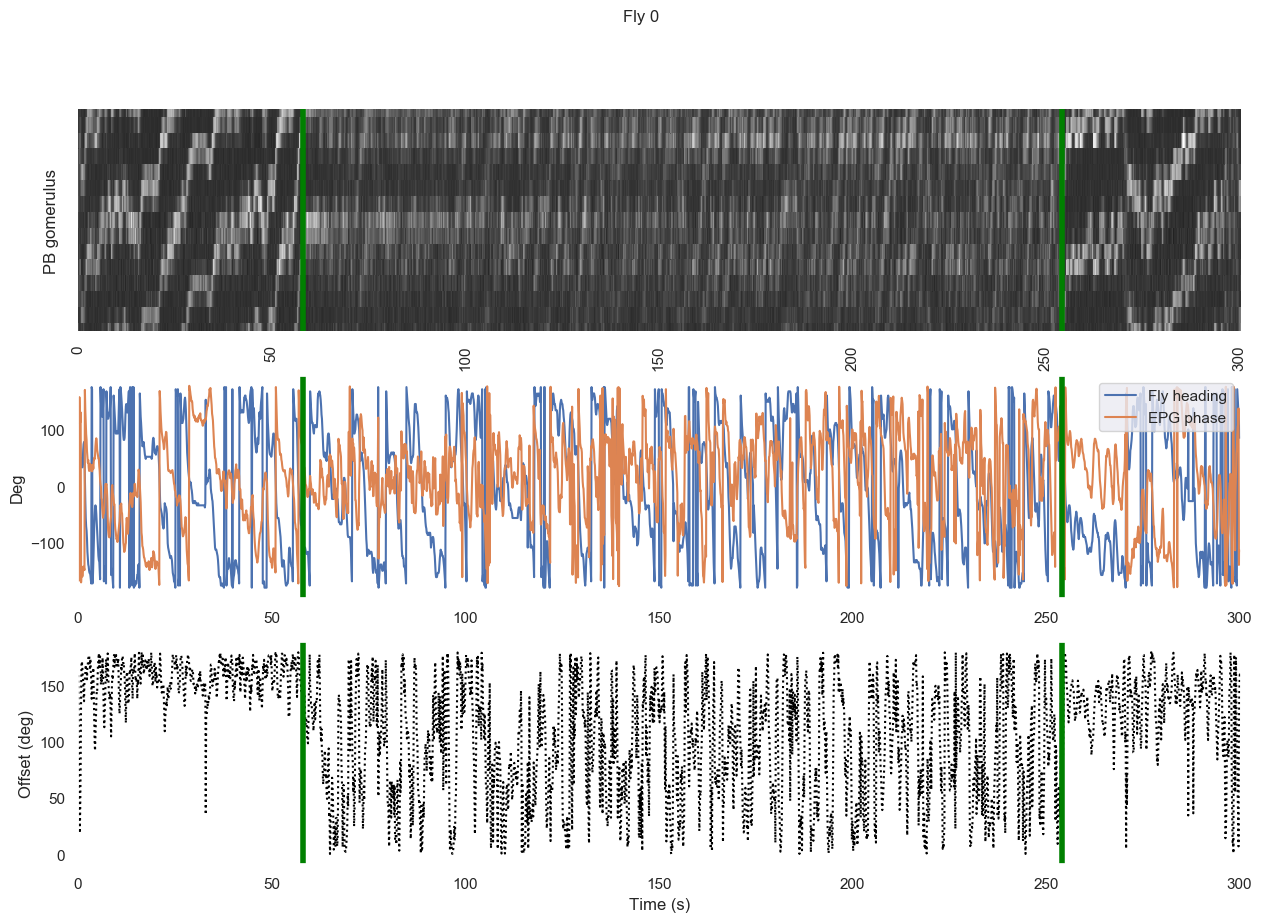

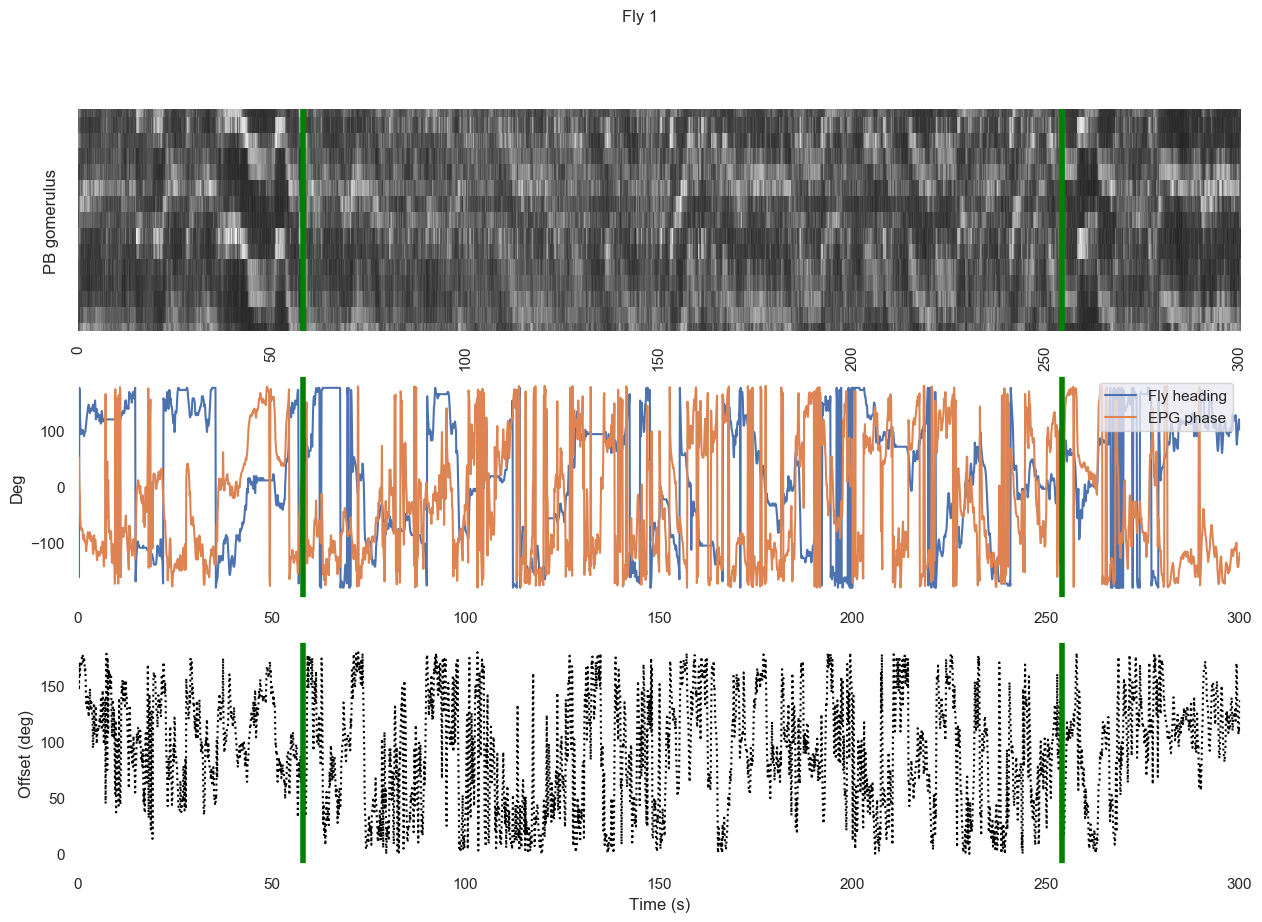

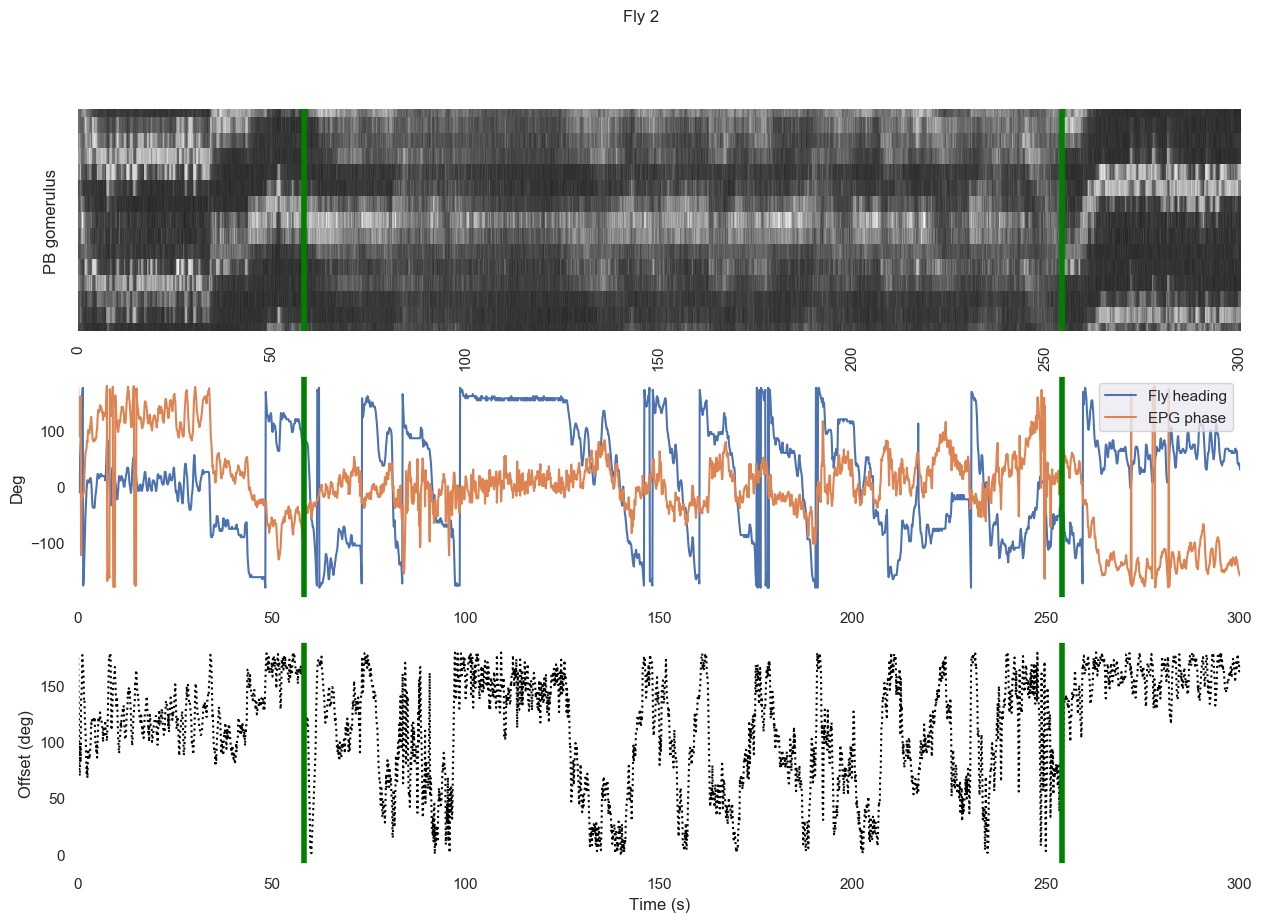

In [10]:
#Using the absolute value for the offset to avoid the jump points at the edges...

for fly in range(flyNum): #for each of the folders
    os.chdir(mainDir + '\data\\' + folders[fly] + '\\dark trial') #move inside of the folder, inside the dark trial folder
    file = os.listdir() #get the file names
    data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
    flyData = data['data'] #store only the data from that dictionnary object into a new object called flyData. This is now a numpy.ndarray
    
    #Find where the panels are turned off and then on
    panelOFF = np.array(np.where(flyData[0,0].fr_y_ds == 1)) #I don't understand why panelOFF has 2 rows. The second one just has zeros. Is there a way to avoid it?
    StartDark = panelOFF[0,0]
    EndDark = panelOFF[0,-1]
    
    #plot heatmap of neural activity
    dff_matrix = flyData[0,0].dff_matrix
    my_cmap = sns.dark_palette("white", as_cmap=True)
    fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)
    fig.suptitle('Fly ' + str(fly))
    g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    g.set_ylabel('PB gomerulus')
    ax1.axvline(x=StartDark, color='green', lw = 4)
    ax1.axvline(x=EndDark, color='green', lw = 4)
    
    
    ax2 = plt.subplot(312, sharex=ax1)
    #ax2.plot(flyData[0,0].time,np.transpose(np.rad2deg(flyData[0,0].panel_angle)))   
    #ax2.plot(flyData[0,0].time,np.transpose(np.rad2deg(flyData[0,0].phase)))
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].panel_angle)))   
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].phase)))   
    ax2.set(xticklabels=[])
    ax2.set(ylabel='Deg')
    ax2.set_facecolor('white')
    #ax2.axvline(x=flyData[0,0].time[StartDark], color='green', lw = 4)
    #ax2.axvline(x=flyData[0,0].time[EndDark], color='green', lw = 4) 
    ax2.axvline(x=StartDark, color='green', lw = 4)
    ax2.axvline(x=EndDark, color='green', lw = 4) 
    ax2.legend(('Fly heading', 'EPG phase'),loc='upper right')
    
    
    ax3 = plt.subplot(313, sharex = ax1)
    #ax3.plot(flyData[0,0].time,np.transpose((np.rad2deg(flyData[0,0].offset))),color ='black',linestyle=':')
    ax3.plot(np.abs(np.transpose((np.rad2deg(flyData[0,0].offset)))),color ='black',linestyle=':')    
    ax3.set_facecolor('white')
    #ax3.axvline(x=flyData[0,0].time[StartDark], color='green', lw = 4)
    #ax3.axvline(x=flyData[0,0].time[EndDark], color='green', lw = 4)
    ax3.axvline(x=StartDark, color='green', lw = 4)
    ax3.axvline(x=EndDark, color='green', lw = 4) 
    plt.ylabel('Offset (deg)')
    plt.xlabel('Time (s)')
    x_locations = np.arange(0, len(flyData[0,0].time), 458)
    ax3.set_xticks(x_locations)
    ax3.set_xticklabels(('0','50','100','150','200','250','300'))


In [12]:
# Load group data

groupData = sio.loadmat(mainDir + '\data\\allDarkData.mat', struct_as_record=True)
flyGroupData = groupData['Data']

#To access the fields in flyGroupData, use flyGroupData.dtype

We call 'offset' the difference between the actual heading of the fly, and the phase value of the EPG network for eery time frame. When animals are given a landmark, such as a bright bar, the offset, even though it differs from fly to fly, becomes pretty stable after the fly has been on the ball for some time. In the darkness, the offset drifts with time. Next, we will look at the offset distributions under certain and undertain conditions.

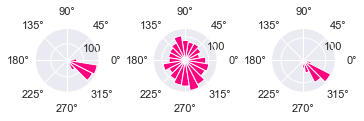

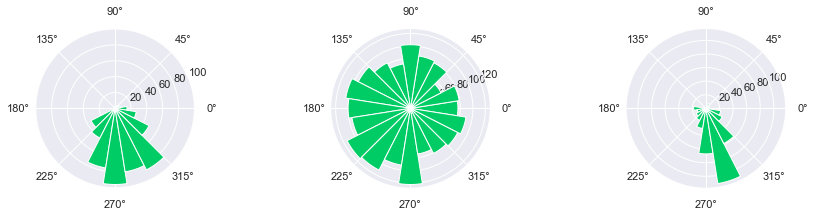

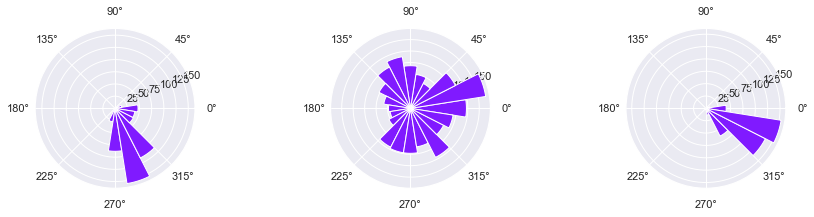

<Figure size 1080x720 with 0 Axes>

In [13]:
# Get and plot the offset distribution for each fly, divided by the certainty state

# Set color palette for flies 
palette = [(1,0,0.5),(0,0.8,0.4),(0.5,0.1,1)]

fig, #(ax1, ax2, ax3) = plt.subplots(3,3, figsize = (15, 10), dpi=100)

bins_number = 20  # the [0, 360) interval will be subdivided into this number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
width = 2 * np.pi / bins_number

for fly in range(flyNum):
    angles1 = flyGroupData[0,fly]['offset'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)]
    angles2 = flyGroupData[0,fly]['offset'][0,np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]
    angles3 = flyGroupData[0,fly]['offset'][0,np.asscalar(flyGroupData[0,fly]['EndDarkness']+1):-1]
    
    n1, _, _ = plt.hist(angles1, bins_number)
    n2, _, _ = plt.hist(angles2, bins_number)
    n3, _, _ = plt.hist(angles3, bins_number)
      
    ax1 = plt.subplot(3, 3, 1, projection='polar')
    ax2 = plt.subplot(3, 3, 2, projection='polar')
    ax3 = plt.subplot(3, 3, 3, projection='polar')
                                                        
    bars1 = ax1.bar(bins[:bins_number], n1, width=width, bottom=0.0, color = palette[fly])
    bars2 = ax2.bar(bins[:bins_number], n2, width=width, bottom=0.0, color = palette[fly])
    bars3 = ax3.bar(bins[:bins_number], n3, width=width, bottom=0.0, color = palette[fly])
         
    plt.show()
    plt.gcf().set_size_inches(15, 10)
        
#I can't change the full figure size, but have only managed to make the first row bigger and not the other two, or the other way around
#The data looks inverted with respect to matlab's, although similar in shape. check where is the difference
#Add titles to columns and rows

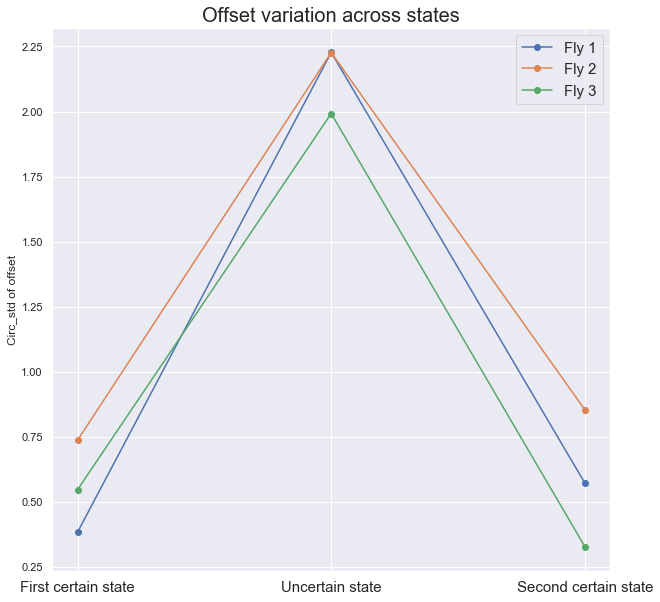

In [14]:
# Get and plot offset variation in each case

offset_variation = np.empty([3, 3])

for fly in range(flyNum):
    offset_variation[fly,0] = circstd(flyGroupData[0,fly]['offset'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)])
    offset_variation[fly,1] = circstd(flyGroupData[0,fly]['offset'][0,np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])
    offset_variation[fly,2] = circstd(flyGroupData[0,fly]['offset'][0,np.asscalar(flyGroupData[0,fly]['EndDarkness']+1):-1])
    
offset_variation = np.transpose(offset_variation)
#newcmp = ListedColormap(palette)
#plt.set_cmap(palette)
plt.plot(offset_variation,marker="o")
plt.ylabel('Circ_std of offset')
plt.title('Offset variation across states',fontsize=20)
plt.xticks([0,1,2], ['First certain state','Uncertain state','Second certain state'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'],fontsize=15)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\OffsetVariationPy.png", dpi=150)

#set colors as in palette

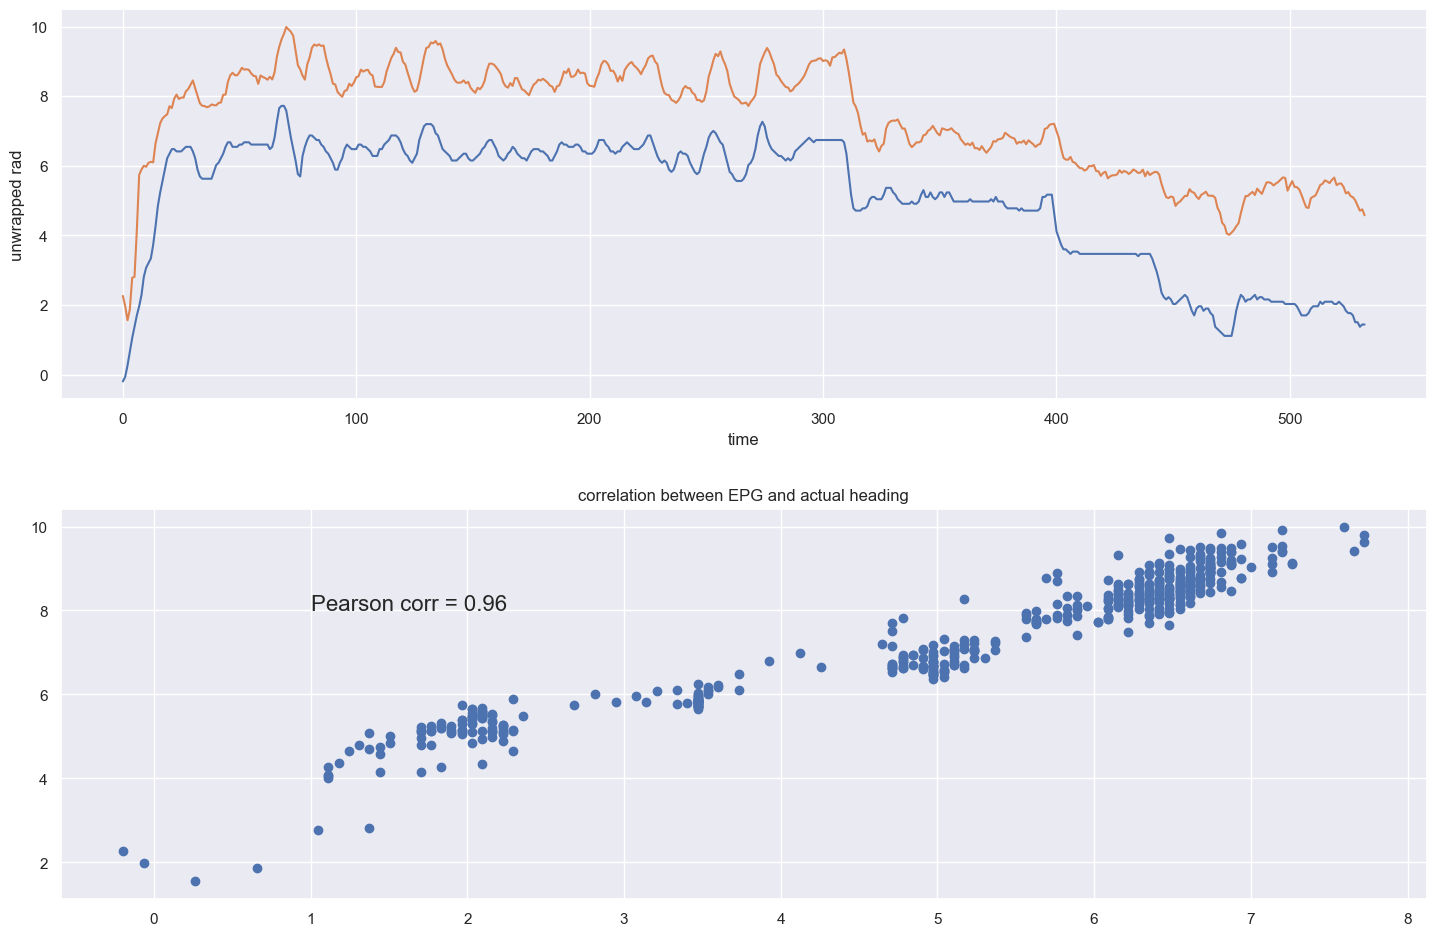

In [15]:
#Analyze the correlation between phase value and fly position

#1) Using the Seelig 2015 method
#Pearson's correlation coefficients were computed between two entire 'unwrapped' time series

#Example fly and state, plot the phase value and actual heading and calculate the correlation
fig,(ax1, ax2) = plt.subplots(2,1, figsize = (15, 10), dpi=100)
ax1.plot(np.unwrap(flyGroupData[0,fly]['panel_angle'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)]))
ax1.plot(np.unwrap(flyGroupData[0,fly]['phase_value'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)]))
ax1.set(ylabel='unwrapped rad')
ax1.set(xlabel='time')

actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)])
decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)])
ax2.scatter(actualHeading,decodedHeading)
ax2.set(title='correlation between EPG and actual heading')
#get correlation
dataCorr = pearsonr(actualHeading,decodedHeading)
ax2.text(1,8,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16)

fig.tight_layout(pad=3.0)

#Looks very correlated!


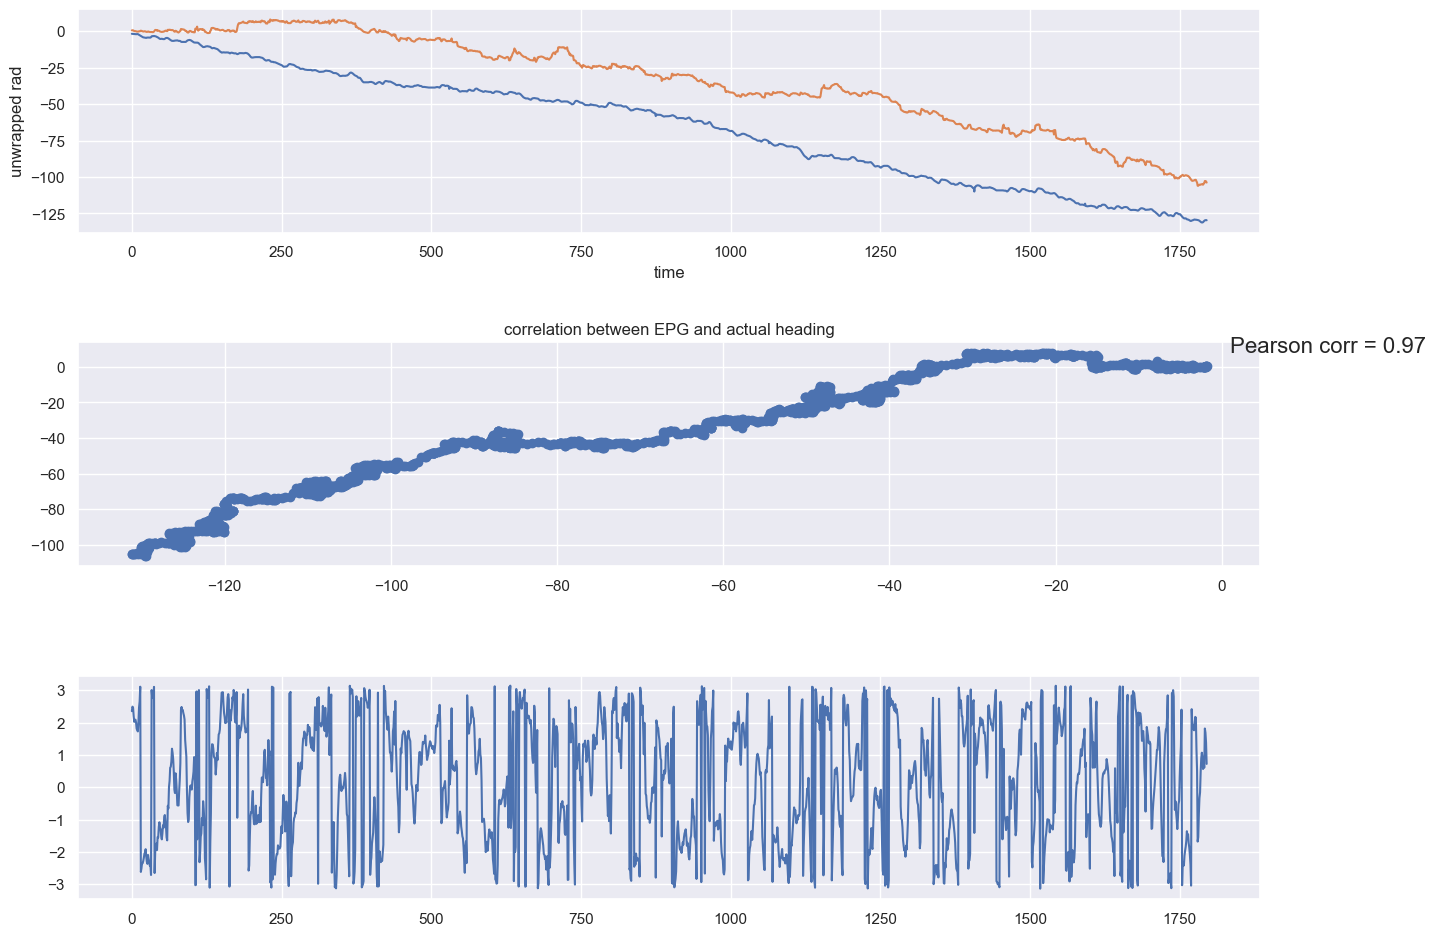

In [16]:
#Example fly and state, plot the phase value and actual heading and calculate the correlation
fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)

actualHeading = np.unwrap(flyGroupData[0,0]['panel_angle'][0,np.asscalar(flyGroupData[0,0]['StartDarkness']):np.asscalar(flyGroupData[0,0]['EndDarkness'])])
decodedHeading = np.unwrap(flyGroupData[0,0]['phase_value'][0,np.asscalar(flyGroupData[0,0]['StartDarkness']):np.asscalar(flyGroupData[0,0]['EndDarkness'])])

ax1.plot(actualHeading)
ax1.plot(decodedHeading)
ax1.set(ylabel='unwrapped rad')
ax1.set(xlabel='time')

ax2.scatter(actualHeading,decodedHeading)
ax2.set(title='correlation between EPG and actual heading')
#get correlation
dataCorr = pearsonr(actualHeading,decodedHeading)
ax2.text(1,8,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16)

ax3.plot(flyGroupData[0,0]['offset'][0,np.asscalar(flyGroupData[0,0]['StartDarkness']):np.asscalar(flyGroupData[0,0]['EndDarkness'])])

fig.tight_layout(pad=3.0)

#This is pretty strange. Even though the offset appears super variable, when we unwrap both time series, they actually look like they correlate a lot.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-0067c987d4f6>", line 18, in <module>
    axs[1,0].text(1,8,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16)
TypeError: type numpy.ndarray doesn't define __round__ method

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_ten

TypeError: type numpy.ndarray doesn't define __round__ method

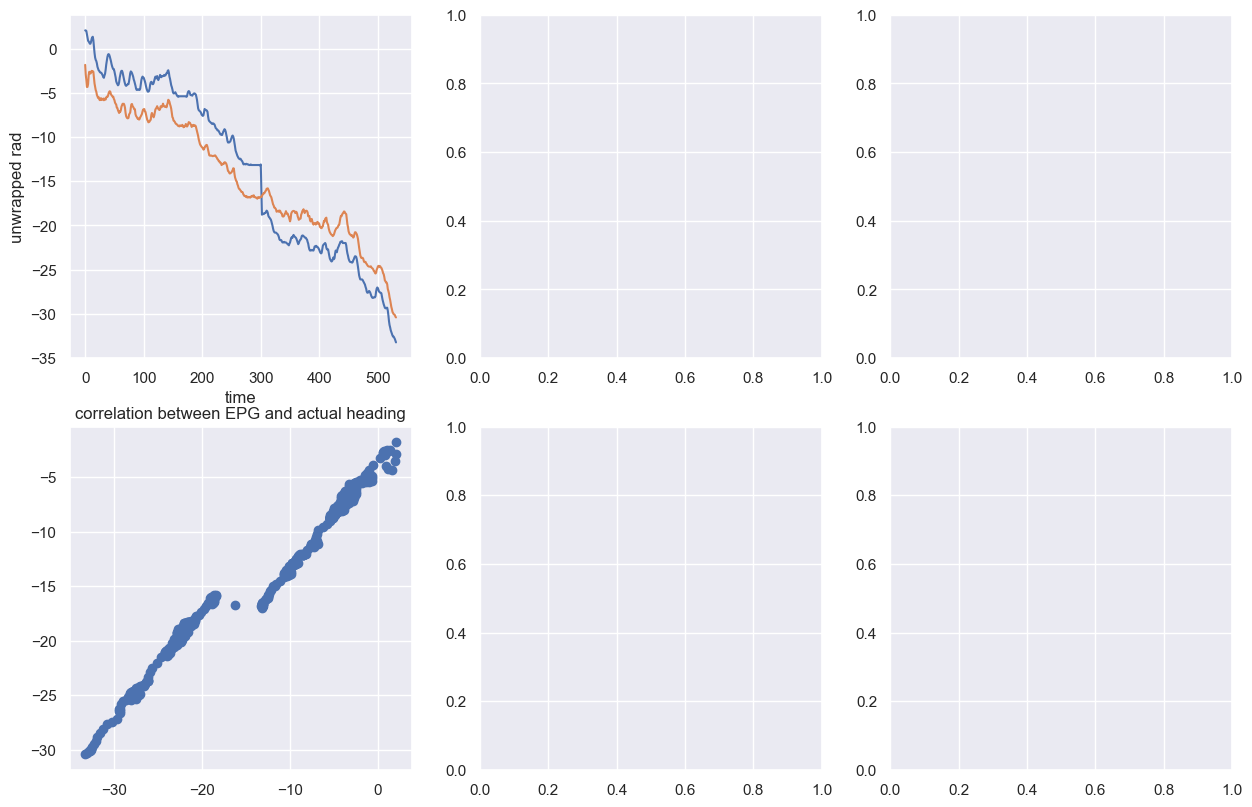

In [17]:
#repeat for every fly and state

dataCorr = np.zeros((flyNum,3))

for fly in range(flyNum):
    fig, axs = plt.subplots(2,3, figsize = (15, 10), dpi=100)
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,1:np.asscalar(flyGroupData[0,fly]['StartDarkness']-1)])   
    axs[0,0].plot(actualHeading)
    axs[0,0].plot(decodedHeading)
    axs[0,0].set(ylabel='unwrapped rad')
    axs[0,0].set(xlabel='time')

    axs[1,0].scatter(actualHeading,decodedHeading)
    axs[1,0].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,0] = pearsonr(actualHeading,decodedHeading)[0]
    axs[1,0].text(1,8,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16)   
    
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])
    axs[0,1].plot(actualHeading)
    axs[0,1].plot(decodedHeading)
    axs[0,1].set(ylabel='unwrapped rad')
    axs[0,1].set(xlabel='time')

    axs[1,1].scatter(actualHeading,decodedHeading)
    axs[1,1].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,1] = pearsonr(actualHeading,decodedHeading)[0]
    #axs[1,0].text(1,8,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16)   
    
    actualHeading = np.unwrap(flyGroupData[0,fly]['panel_angle'][0,np.asscalar(flyGroupData[0,fly]['EndDarkness']+1):-1])
    decodedHeading = np.unwrap(flyGroupData[0,fly]['phase_value'][0,np.asscalar(flyGroupData[0,fly]['EndDarkness']+1):-1])
    axs[0,2].plot(actualHeading)
    axs[0,2].plot(decodedHeading)
    axs[0,2].set(ylabel='unwrapped rad')
    axs[0,2].set(xlabel='time')

    axs[1,2].scatter(actualHeading,decodedHeading)
    axs[1,2].set(title='correlation between EPG and actual heading')
    #get correlation
    dataCorr[fly,2] = pearsonr(actualHeading,decodedHeading)[0]
    #axs[1,0].text(0.5,0.5,'Pearson corr = ' + str(round(dataCorr[0],2)), fontsize=16, transform = axs.transAxes)     

    fig.tight_layout(pad=3.0)

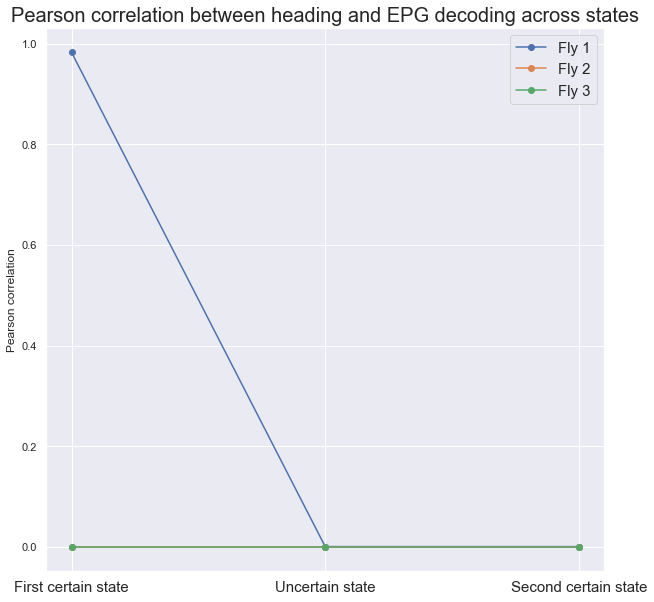

In [18]:
#Plot correlation

plt.plot(abs(np.transpose(dataCorr)),marker="o")
plt.ylabel('Pearson correlation')
plt.title('Pearson correlation between heading and EPG decoding across states',fontsize=20)
plt.xticks([0,1,2], ['First certain state','Uncertain state','Second certain state'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'],fontsize=15)
plt.gcf().set_size_inches(10, 10)

#The correlation doesn't look amazing for every 

In [19]:
# Calculate bump magnitude as max - min for every frame

def stat_range(x):
    return max(x) - min(x)

#for each fly, calculate range
newData = []
state = []
smoothedData = []
frames = np.shape(flyGroupData[0,0]['dff_matrix'])[1]

for fly in range(flyNum):
        newData.append(np.apply_along_axis(stat_range, 0, flyGroupData[0,fly]['dff_matrix']))
        state.extend(np.repeat(np.array(1),flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(2),flyGroupData[0,fly]['EndDarkness'][0,0]-flyGroupData[0,fly]['StartDarkness'][0,0]))
        state.extend(np.repeat(np.array(3),frames-flyGroupData[0,fly]['EndDarkness'][0,0]))
        smoothedData.append(gaussian_filter(newData[fly], sigma=5)) #change sigma for the smoothing window
                
bumpData = np.reshape(np.array(newData),flyNum*len(newData[0]))
smoothedBumpData = np.reshape(np.array(smoothedData),flyNum*len(smoothedData[0]))
flyID = np.repeat(np.array(range(flyNum))+1,frames)
time = [flyData[0,0].time,flyData[0,0].time,flyData[0,0].time]
time = np.reshape(time,frames*3)

# Combine all the data in a dataframe
bumpdata = {'Fly ID': flyID, 'State': state, 'BumpMagMinMax': bumpData, 'Time': time, 'SmoothedBumpMagMinMax': smoothedBumpData}
bumpDF = pd.DataFrame(bumpdata)

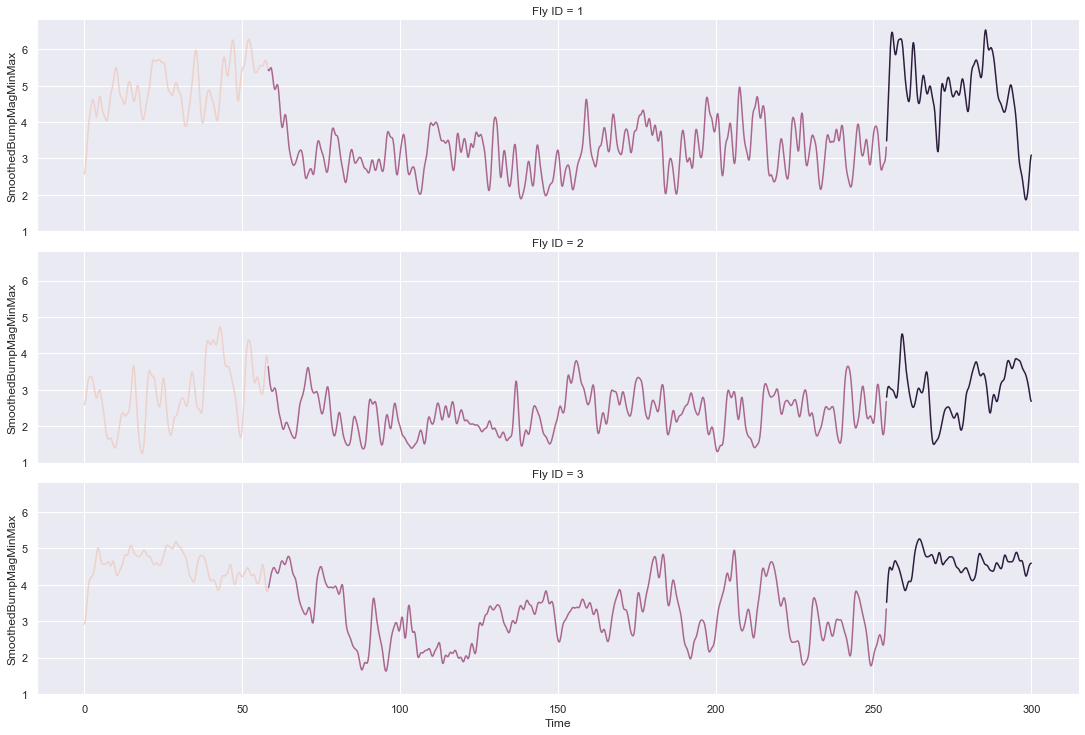

In [21]:
# Plot the bump magnitude in time for max-min

g = sns.relplot("Time", "SmoothedBumpMagMinMax", data=bumpDF, row='Fly ID', hue = 'State', kind="line")
g._legend.remove()
plt.gcf().set_size_inches(20, 10)
plt.savefig(mainDir + "\plots\BumpMagPy.png", dpi=150)

0.03004217137407778
0.06455629459430456
0.009041942093505905


C:\Users\Melanie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


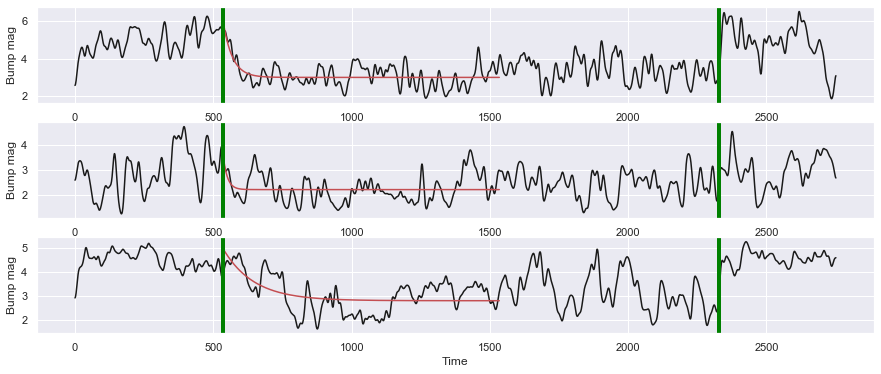

In [23]:
# Do a least square exponential decay fit with t=0 as the moment when the stim changes, and using different time windows.

def expFit(x, a, b, c):
    return a * np.exp(-b * x) + c

fig, axs = plt.subplots(3,1, figsize=(15, 6))
    
for fly in range(flyNum):
    totalTime = np.linspace(0, len(smoothedData[fly]), len(smoothedData[fly]))
    startFit = StartDark
    fitWindow = 1000
    endFit = startFit + fitWindow
    fitTime = np.linspace(0, endFit-startFit, (endFit-startFit))
    popt, pcov = curve_fit(expFit, fitTime, smoothedData[fly][startFit:endFit])
    axs[fly].plot(totalTime, smoothedData[fly], 'k')
    axs[fly].plot(fitTime + StartDark, expFit(fitTime, *popt), 'r-')
    axs[fly].axvline(x=StartDark, color='green', lw = 4)
    axs[fly].axvline(x=EndDark, color='green', lw = 4) 
    print(popt[1]) #print the decay time. They are all pretty different
    axs[fly].set_ylabel('Bump mag')
    plt.xlabel('Time')    
    
plt.savefig(mainDir + "\plots\BumpMagInTimePy.png", dpi=150)

In [25]:
# Get bump magnitude as PVA amplitude (I need the PVA amplitude and not PVA value)


In [26]:
# Plot the bump magnitude in time for pva



In [27]:
# Get bump magnitude as the power value of the FFT

ftData = []
smoothedFtData = []

for fly in range(flyNum):
    ftData.extend (np.array(flyGroupData[0,fly]['ftpower']))
    smoothedFtData.append(gaussian_filter(ftData[fly], sigma=5))
    
ftBumpData = np.reshape(np.array(ftData),flyNum*len(ftData[0]))
smoothedFtBumpData = np.reshape(np.array(smoothedFtData),flyNum*len(smoothedFtData[0]))
bumpDF['ftpower'] = ftBumpData
bumpDF['smoothedftpower'] = smoothedFtBumpData

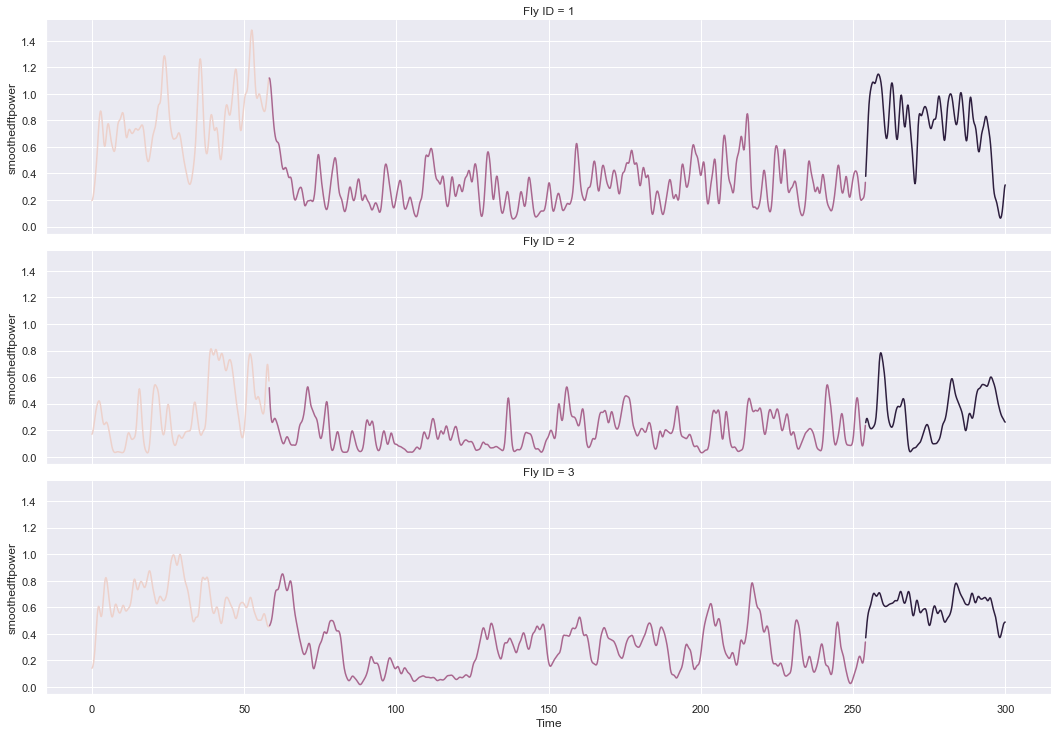

In [28]:
# Plot the bump magnitude in time for fft power

g = sns.relplot("Time", "smoothedftpower", data=bumpDF, row='Fly ID', hue = 'State', kind="line")
g._legend.remove()
plt.gcf().set_size_inches(20, 10)

0.038962487539222344
0.08521047101073899
0.01205570945809494


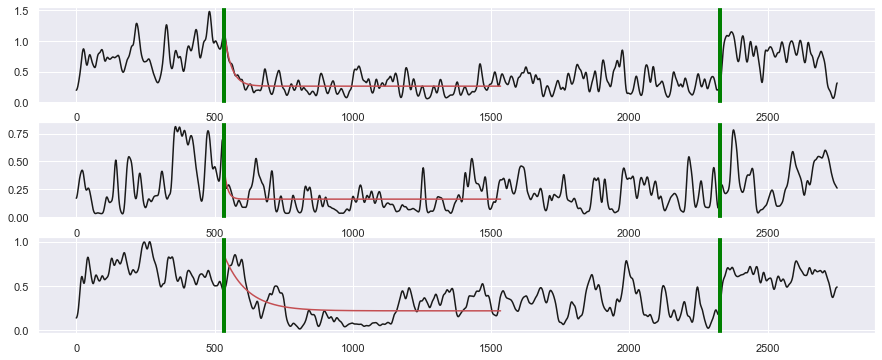

In [29]:
# Exponential decay fit using ft power data

fig, axs = plt.subplots(3,1, figsize=(15, 6))
    
for fly in range(flyNum):
    totalTime = np.linspace(0, len(smoothedFtData[fly]), len(smoothedFtData[fly]))
    startFit = StartDark
    fitWindow = 1000
    endFit = startFit + fitWindow
    fitTime = np.linspace(0, endFit-startFit, (endFit-startFit))
    popt, pcov = curve_fit(expFit, fitTime, smoothedFtData[fly][startFit:endFit])
    axs[fly].plot(totalTime, smoothedFtData[fly], 'k')
    axs[fly].plot(fitTime + StartDark, expFit(fitTime, *popt), 'r-')
    axs[fly].axvline(x=StartDark, color='green', lw = 4)
    axs[fly].axvline(x=EndDark, color='green', lw = 4) 
    print(popt[1]) #print the decay time. They are all pretty different

In [30]:
# Get bump magnitude as the summed fluorescence across glomeruli

summedDFF = []
smoothedSummedDFF = []

for fly in range(flyNum):
    summedDFF.append(sum(flyGroupData[0,fly]['dff_matrix']))
    smoothedSummedDFF.append(gaussian_filter(summedDFF[fly], sigma=5))
    
summedDFFBump = np.reshape(np.array(summedDFF),flyNum*len(summedDFF[0]))
smoothedSummedDFFBump = np.reshape(np.array(smoothedSummedDFF),flyNum*len(smoothedSummedDFF[0]))
bumpDF['summedDFF'] = summedDFFBump
bumpDF['smoothedSummedDFF'] = smoothedSummedDFFBump

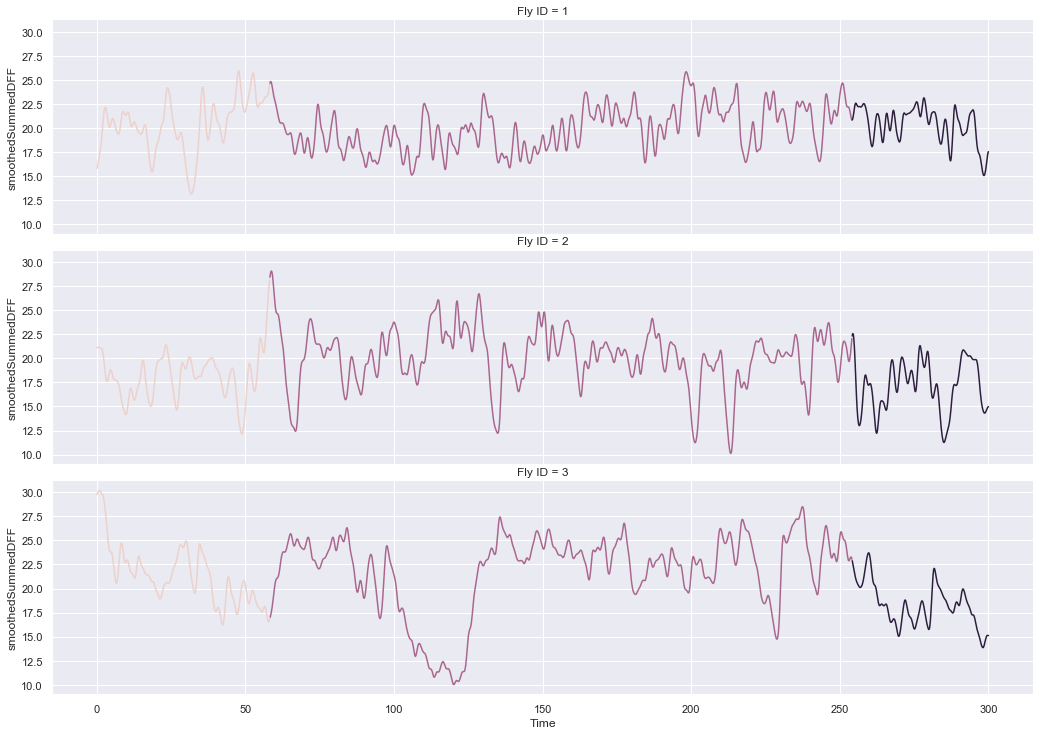

In [31]:
# Plot the bump magnitude in time for summed DFF

g = sns.relplot("Time", "smoothedSummedDFF", data=bumpDF, row='Fly ID', hue = 'State', kind="line")
g._legend.remove()
plt.gcf().set_size_inches(20, 10)

#This looks pretty bad

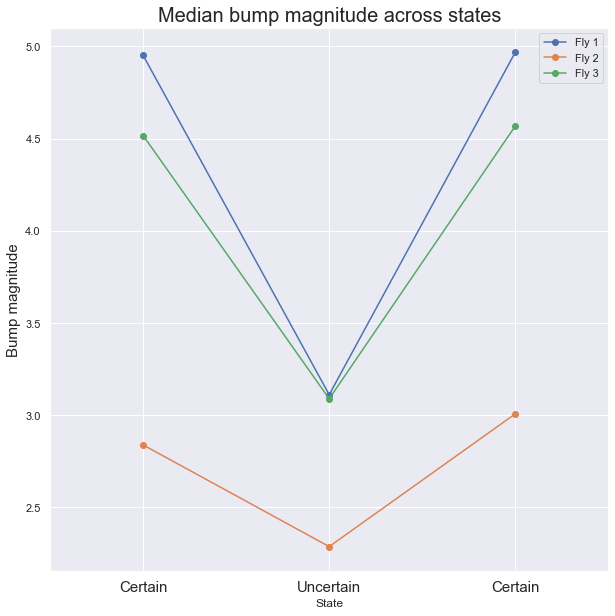

In [34]:
# Calculate and plot median bump magnitude for each state

medianBump = bumpDF.groupby(['State','Fly ID'])[['BumpMagMinMax']].median()
bumpDF.groupby(['State','Fly ID'])[['BumpMagMinMax']].median().unstack().plot(marker="o")
plt.ylabel('Bump magnitude',fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
plt.gcf().set_size_inches(10, 10)
plt.title('Median bump magnitude across states',fontsize=20)
plt.savefig(mainDir + "\plots\BumpMagAcrossStatesPy.png", dpi=150)
#change color

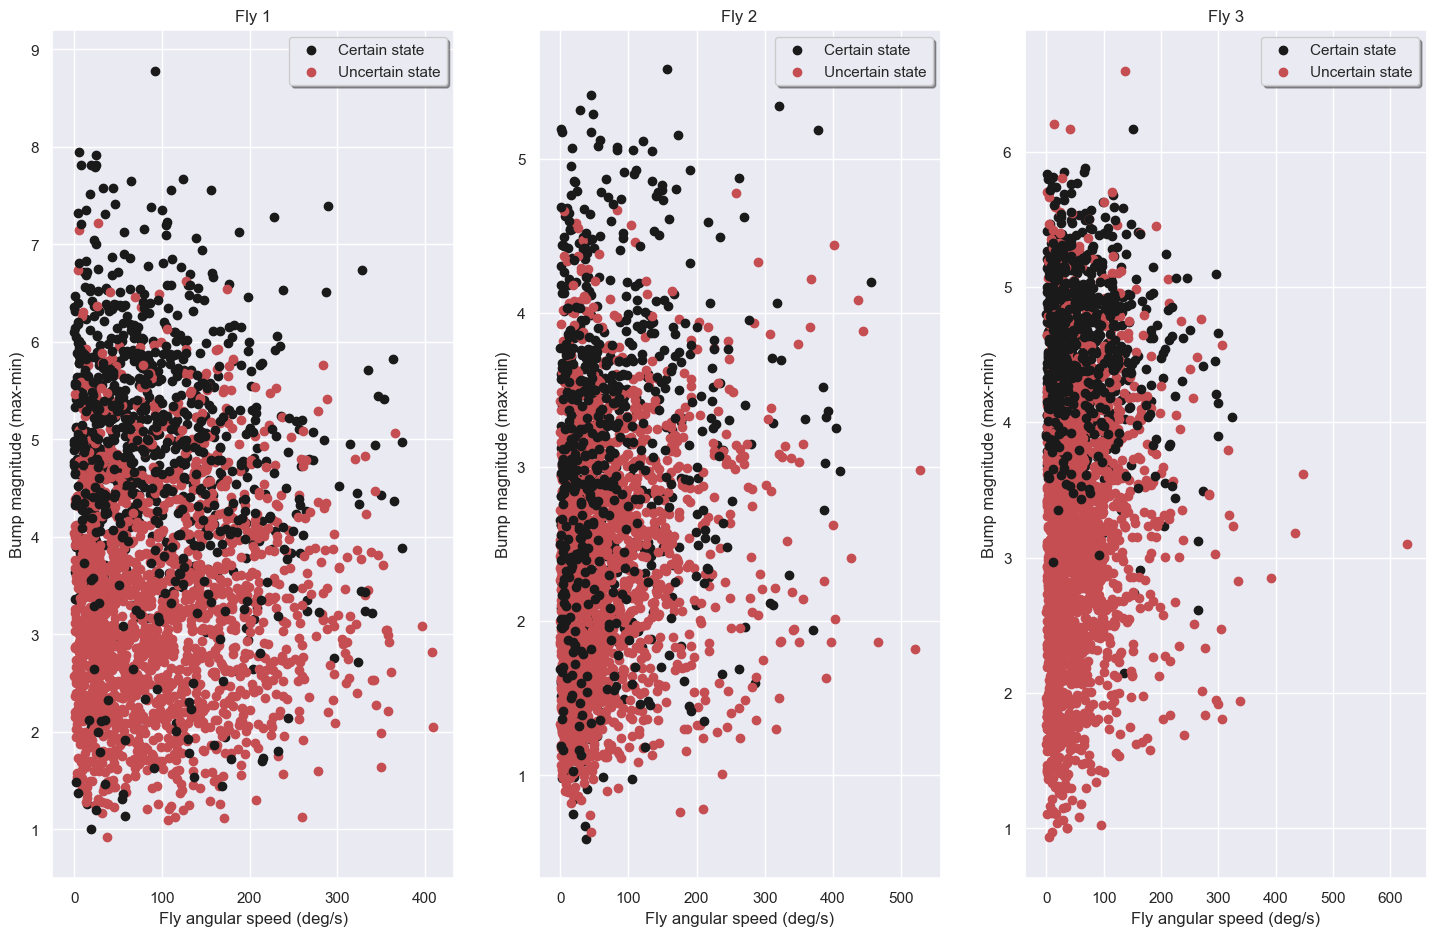

In [35]:
# Scatter of bump magnitude vs fly angular speed

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(np.rad2deg(abs(flyGroupData[0,fly]['ang_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])])),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='k')
    ax.scatter(np.rad2deg(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(np.rad2deg(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1])),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump magnitude (max-min)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')

fig.tight_layout(pad=3.0)
plt.savefig(mainDir + "\plots\BumpMagVsFlySpeed.png", dpi=150)

#correct the enddarkness-1

In [36]:
# Binning the velocity

flyAngSpeed = []

for fly in range(flyNum):
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]))
        flyAngSpeed.extend(abs(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1]))

#make binned plot

In [37]:
bumpDF['flyAngSpeed'] = flyAngSpeed
bins = [0.25,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,4]
test = pd.cut(bumpDF['flyAngSpeed'], bins)
bumpDF['test'] = test

#g = sns.relplot("flyAngSpeed", "BumpMag", data=bumpDF, col='Fly ID', hue = 'State', kind="line")
bumpDF.groupby(['Fly ID', 'State', 'test']).BumpMag.median().plot(kind='line')

#figure out how to make the binned plot

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-e4a74e5bca3a>", line 7, in <module>
    bumpDF.groupby(['Fly ID', 'State', 'test']).BumpMag.median().plot(kind='line')
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py", line 566, in __getattr__
    "%r object has no attribute %r" % (type(self).__name__, attr)
AttributeError: 'DataFrameGroupBy' object has no attribute 'BumpMag'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Melanie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Tra

AttributeError: 'DataFrameGroupBy' object has no attribute 'BumpMag'

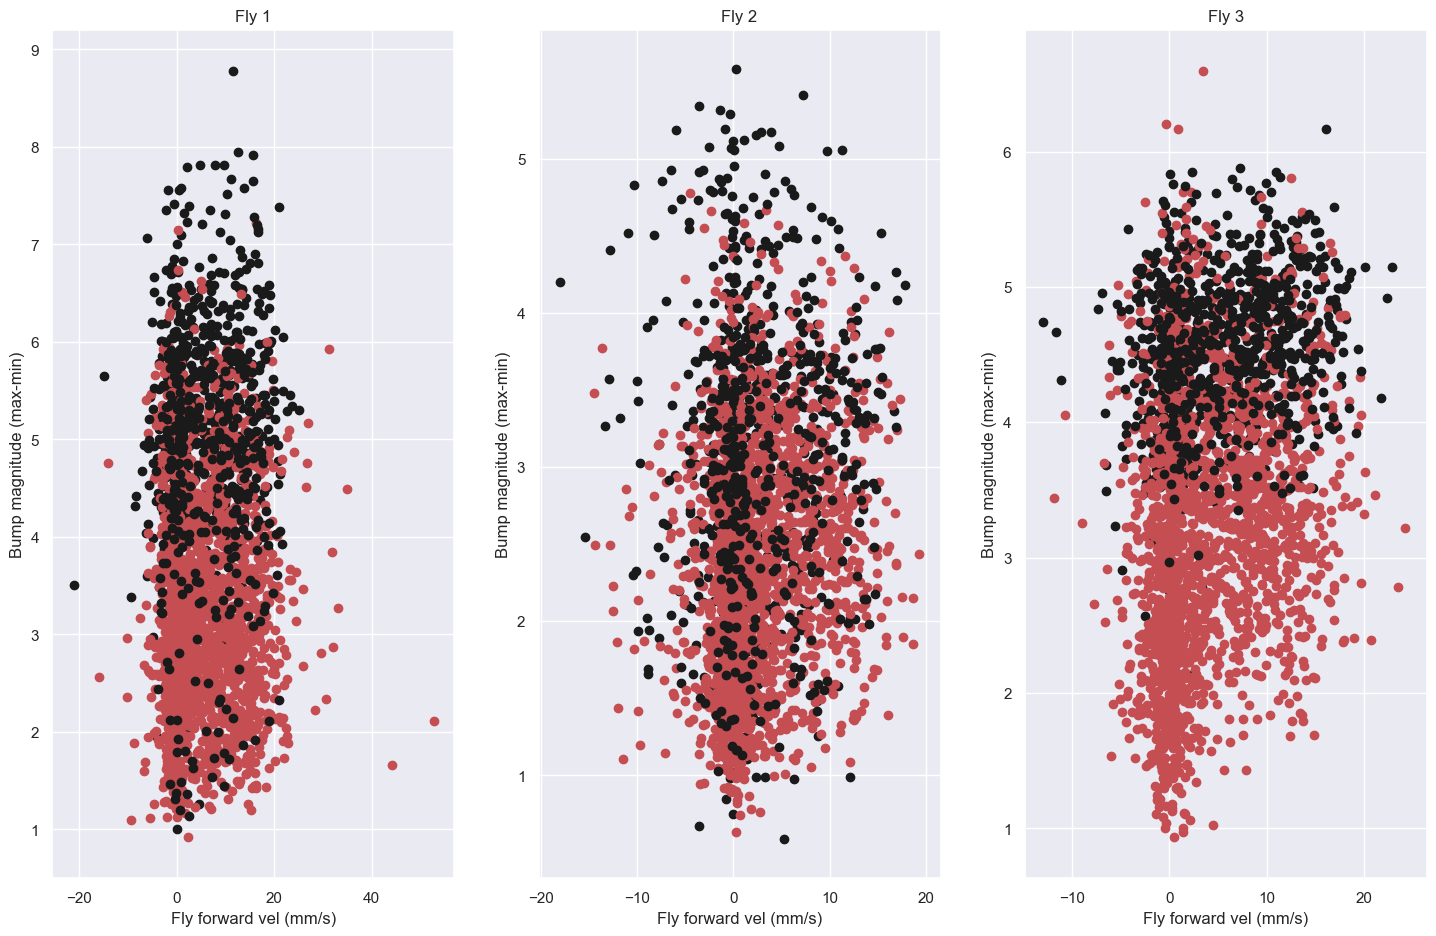

In [38]:
# Scatter of bump magnitude vs fly forward velocity

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)] ,c='k')
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)] ,c='r')
    ax.scatter(4.5*(flyGroupData[0,fly]['for_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1]),bumpData[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)] ,c='k')  
    plt.xlabel('Fly forward vel (mm/s)')
    plt.ylabel('Bump magnitude (max-min)')
    plt.title('Fly ' + str(fly+1))

fig.tight_layout(pad=3.0)
plt.savefig(mainDir + "\plots\BumpMagVsFlyFwdVelPy.png", dpi=150)

#correct the enddarkness-1

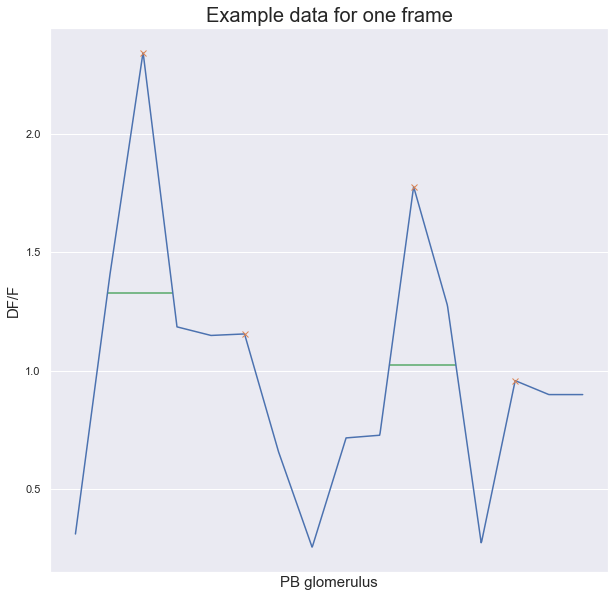

In [39]:
#Calculate bump width at half max for 1 example timepoint and plot.

exampleData = np.interp(np.linspace(1,16,1000),range(len(flyGroupData[0,0]['dff_matrix'][:,3])),flyGroupData[0,0]['dff_matrix'][:,3])
#find the peaks
peaks, _ = find_peaks(exampleData)
#retain the taller 2 peaks (2 bumps)
peakValues = exampleData[peaks]
MinToMaxOrder = np.argsort(peakValues)
MaxToMinOrder = np.flip(MinToMaxOrder)
Peaks = peaks[MaxToMinOrder[0:2]]
#plot
results_half = peak_widths(exampleData, Peaks, rel_height=0.5)
plt.plot(exampleData)
plt.xlabel('PB glomerulus',fontsize=15)
plt.ylabel('DF/F',fontsize=15)
plt.xticks(ticks=[], labels=[])
plt.plot(peaks, exampleData[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.gcf().set_size_inches(10, 10)
plt.title('Example data for one frame',fontsize = 20)
#plt.savefig("ExampleBumpWidthAtHalfMax.png", dpi=150)

#save the data and average both widths
allHalfWidths = results_half[0]
meanHalfWidth = np.mean(allHalfWidths)*16/1000


In [40]:
# Calculate the width at half max for every frame for every fly

interpData = np.zeros((1000,frames,flyNum))
allHalfWidths = np.zeros((flyNum,frames,2))
meanHalfWidth = np.zeros((flyNum,frames))

for fly in range(flyNum):
    for frame in range(frames):
        interpData[:,frame,fly] = np.interp(np.linspace(1,16,1000),range(len(flyGroupData[0,fly]['dff_matrix'][:,frame])),flyGroupData[0,fly]['dff_matrix'][:,frame])
        peaks, _ = find_peaks(interpData[:,frame,fly])
        #retain the taller 2 peaks (2 bumps)
        peakValues = interpData[peaks,frame,fly]
        MinToMaxOrder = np.argsort(peakValues)
        MaxToMinOrder = np.flip(MinToMaxOrder)
        Peaks = peaks[MaxToMinOrder[0:2]]
        results_half = peak_widths(interpData[:,frame,fly], Peaks, rel_height=0.5)
        allHalfWidths[fly,frame,:] = results_half[0]
        meanHalfWidth[fly,frame] = np.mean(allHalfWidths[fly,frame,:])*16/1000


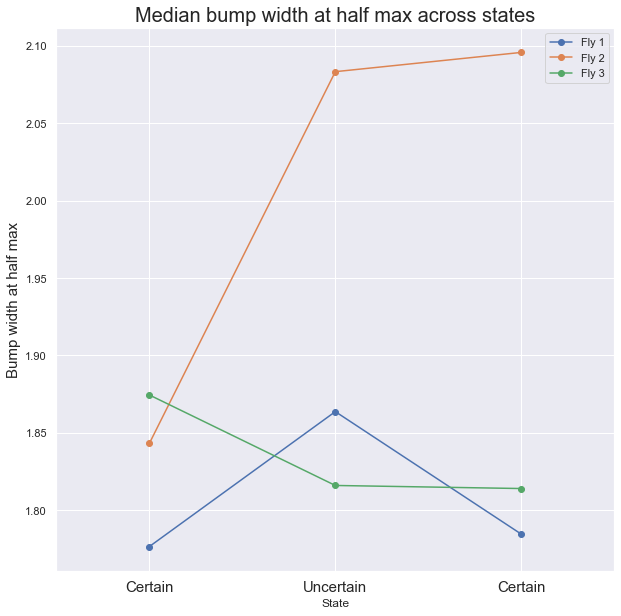

In [41]:
# Get the median width at half max for each fly and each state and plot

HalfWidthMax = np.reshape(meanHalfWidth,3*frames)
bumpDF['HalfWidthMax'] = HalfWidthMax

bumpDF.groupby(['State','Fly ID'])[['HalfWidthMax']].median().unstack().plot(marker="o")
plt.ylabel('Bump width at half max', fontsize=15)
plt.xticks([1,2,3], ['Certain','Uncertain','Certain'],fontsize=15)
plt.legend(['Fly 1', 'Fly 2', 'Fly 3'])
plt.xlim(0.5,3.5)
plt.title('Median bump width at half max across states', fontsize=20)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpWidthAtHalfMaxPy.png", dpi=150)
#add errorbars

In [16]:
# Bump width at half max using a Von Mises fit

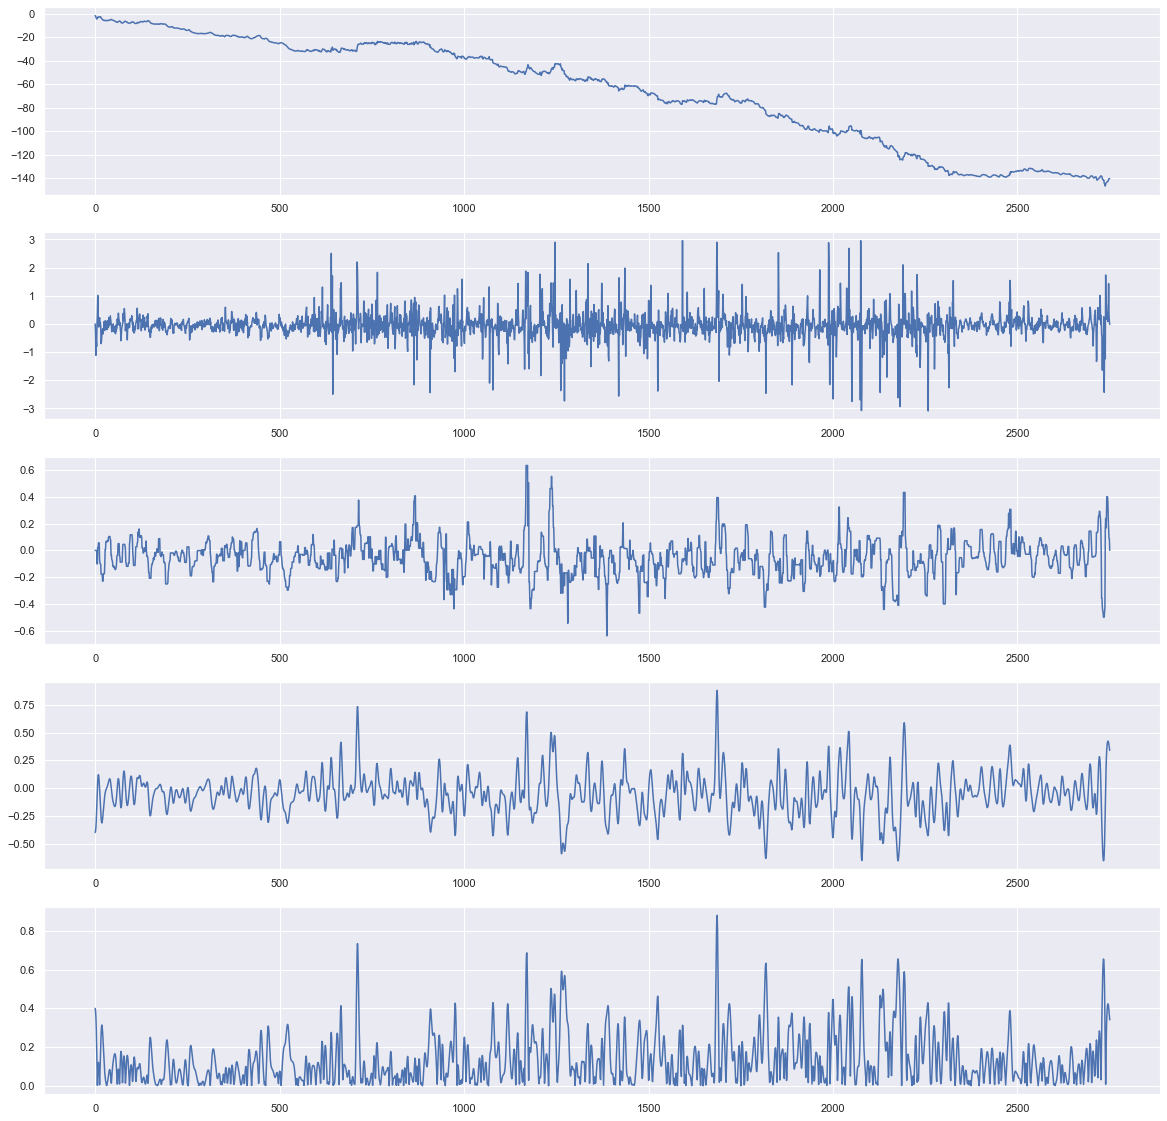

In [42]:
# Bump angular speed per state
unwrappedPhase = np.zeros((flyNum,frames))
diffUnwrapped = np.zeros((flyNum,frames))
smoothedDiff = np.zeros((flyNum,frames))
smoothedDiff2 = np.zeros((flyNum,frames))

# Get the bump's angular speed
for fly in range(flyNum):
    unwrappedPhase[fly] = np.unwrap(flyGroupData[0,fly]['phase_value'])
    diffUnwrapped[fly] = np.append(0,np.ediff1d(unwrappedPhase[fly]))
    smoothedDiff[fly] = medfilt(diffUnwrapped[fly], 11)  
    smoothedDiff2[fly] = gaussian_filter(diffUnwrapped[0], sigma=3) #does this sigma represent frames? How do I choose the appropriate one?
#I don't think this is a great smoothing, I need to check.

fig,
ax1 = plt.subplot(511)
ax1.plot(unwrappedPhase[0])
ax2 = plt.subplot(512)
ax2.plot(diffUnwrapped[0])
ax3 = plt.subplot(513)
ax3.plot(smoothedDiff[0])
ax4 = plt.subplot(514)
ax4.plot(smoothedDiff2[0])
ax5 = plt.subplot(515)
ax5.plot(abs(smoothedDiff2[0]))

plt.gcf().set_size_inches(20, 20)


# Add to data frame
bumpAngSpeed = abs(np.rad2deg(np.reshape(smoothedDiff,3*frames)))
bumpDF['bumpAngSpeed'] = bumpAngSpeed

#Should I be dividing the bump ang speed by the animal's ang speed? Otherwise it might be that the bump appears to increase in velocity because the animal is moving more.
#Thinking about this, I should also compare total movement between the different conditions.

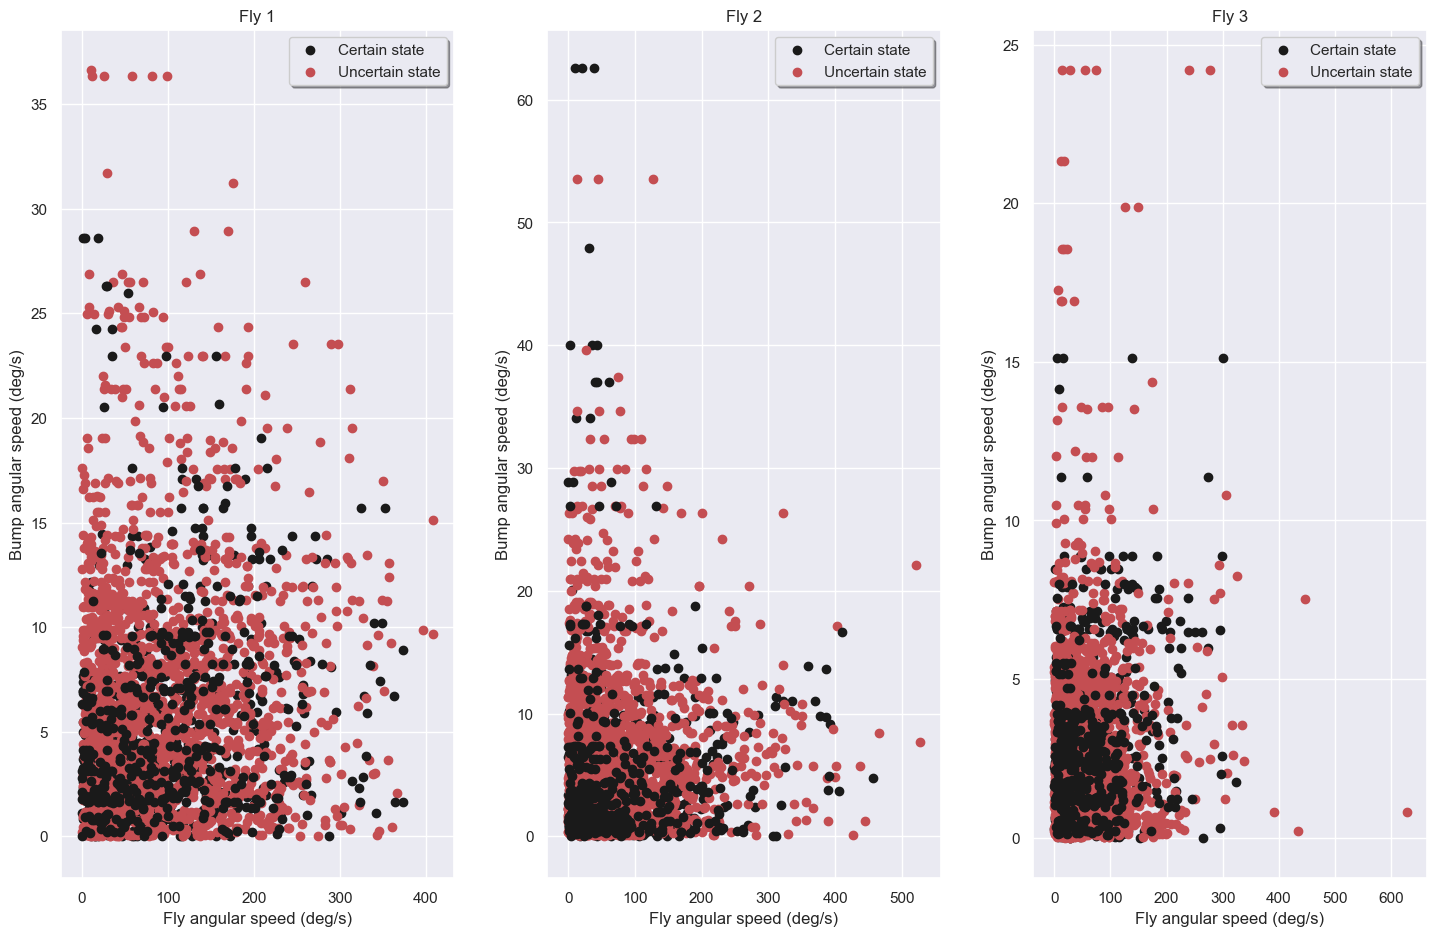

In [43]:
# Scatter of bump and vel vs fly and vel

bumpAngVel = np.rad2deg(np.reshape(smoothedDiff,3*frames))
bumpDF['bumpAngVel'] = bumpAngVel

fig = plt.figure(figsize = (15, 10), dpi=100)
for fly in range(flyNum):
    ax = fig.add_subplot(1, 3, fly+1)
    ax.scatter(abs(np.rad2deg(flyGroupData[0,fly]['ang_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])])),abs(bumpAngVel[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)]) ,c='k')
    ax.scatter(abs(np.rad2deg(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])])),abs(bumpAngVel[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)]) ,c='r')
    ax.scatter(abs(np.rad2deg(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['EndDarkness']-1):-1])),abs(bumpAngVel[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 3)]) ,c='k')  
    plt.xlabel('Fly angular speed (deg/s)')
    plt.ylabel('Bump angular speed (deg/s)')
    plt.title('Fly ' + str(fly+1))
    ax.legend(('Certain state','Uncertain state'), loc='upper right', frameon='True', shadow = 'True')

fig.tight_layout(pad=3.0)
plt.savefig(mainDir + "\plots\BumpSpeedVsFlySpeed.png", dpi=150)

#the bump vel doesn't appear correlated with the fly's angular vel, which is very weird... I need to double check the fly's velocity data with jenny.

In [44]:
#calculate correlation between bump speed and fly speed

from scipy.stats import pearsonr
uncertainSpeedData = abs(np.rad2deg(flyGroupData[0,fly]['ang_vel'][np.asscalar(flyGroupData[0,fly]['StartDarkness']):np.asscalar(flyGroupData[0,fly]['EndDarkness'])]))
uncertainBumpData = abs(bumpAngVel[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 2)])

certainSpeedData = abs(np.rad2deg(flyGroupData[0,fly]['ang_vel'][0:np.asscalar(flyGroupData[0,fly]['StartDarkness'])]))
certainBumpData = abs(bumpAngVel[(bumpDF['Fly ID'] == fly+1) & (bumpDF['State'] == 1)])


corr, _ = pearsonr(certainSpeedData[:,0], certainBumpData)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.277


In [193]:
# Binning the fly angular speed
#add fly speed data to the data frame
#bumpDF['binnedFlySpeed'] = pd.qcut(bumpDF['bumpFlySpeed'], q=6)

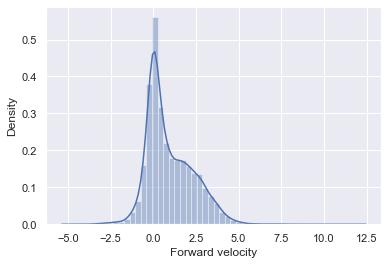

In [45]:
# Diving the data in standing and walking bouts

# Get all the forward velocities and plot histogram
allWalkingVelocities = np.concatenate((flyGroupData[0,0]['for_vel'],flyGroupData[0,1]['for_vel'],flyGroupData[0,2]['for_vel']))
densityVal = np.asarray(sns.distplot(allWalkingVelocities).get_lines()[0].get_data())
plt.xlabel('Forward velocity')
plt.ylabel('Density')
plt.savefig(mainDir + "\plots\VelThreshold.png", dpi=150)

# Determine the threshold between standing and moving as the valley between the two peaks in the distribution
I = np.argmax(densityVal[1,:])
I2 = np.argmin(abs(densityVal[1,I+1:-1]-(densityVal[1,I]/2)))
thresholdVel = densityVal[0,I+I2]

#whenever I use argmax and argmin, I get different values that in matlab.
#I'm also getting a different threshold velocity, although it might be differences in the density estimation in both languages

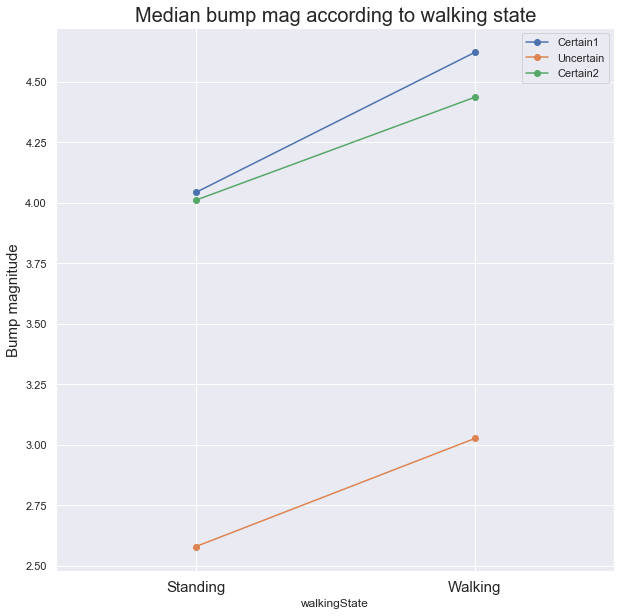

In [46]:
# Get and plot bump magnitude in walking and standing bouts for every state

#Find data points above the velocity threshold
walkingBouts = allWalkingVelocities>thresholdVel
bumpDF['walkingState'] = walkingBouts
#figure out how to plot in different rows/columns using these variables

bumpDF.groupby(['walkingState','State'])['BumpMagMinMax'].mean()
bumpDF.groupby(['walkingState','State'])[['BumpMagMinMax']].median().unstack().plot(marker='o')
plt.ylabel('Bump magnitude', fontsize=15)
plt.xticks([0,1], ['Standing','Walking'],fontsize=15)
plt.legend(['Certain1', 'Uncertain', 'Certain2'])
plt.xlim(-0.5,1.5)
plt.title('Median bump mag according to walking state', fontsize=20)
plt.gcf().set_size_inches(10, 10)
plt.savefig(mainDir + "\plots\BumpMagWithState.png", dpi=150)

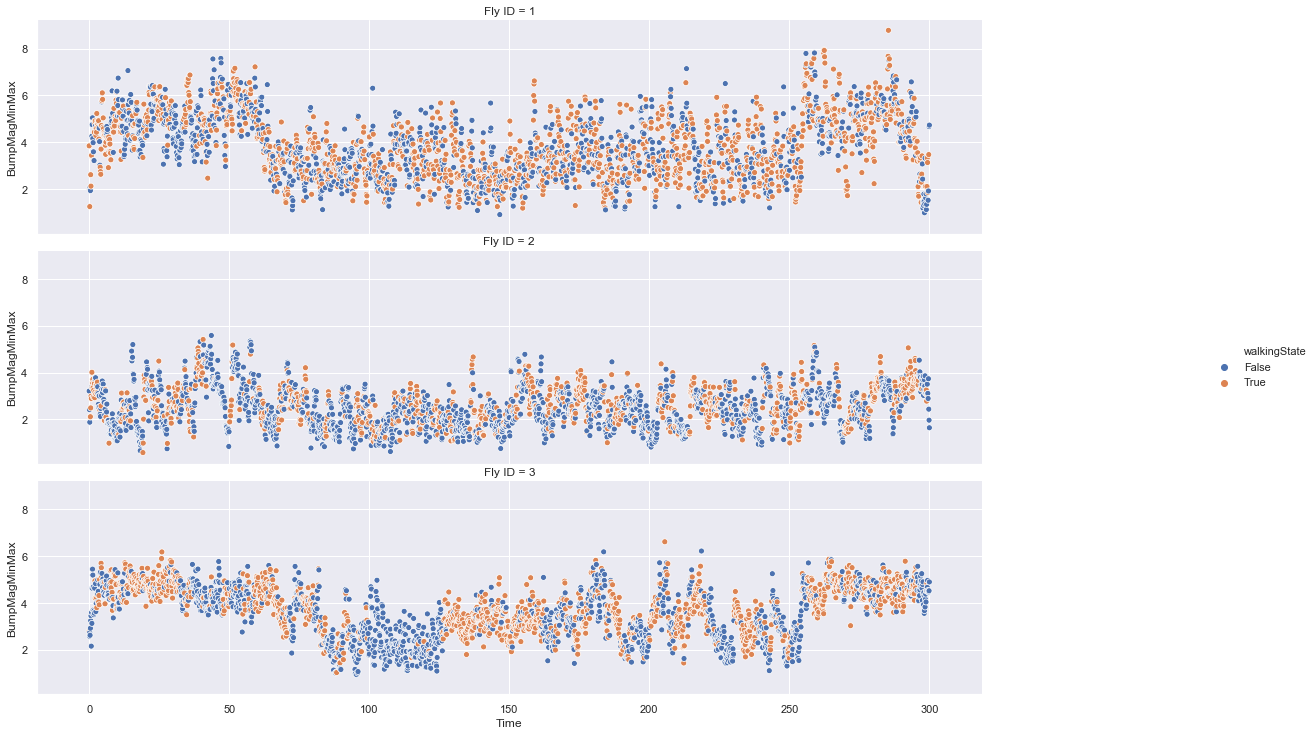

In [47]:
# Plot bump magnitude in time, coloring according to the walking/standing status

g = sns.relplot("Time", "BumpMagMinMax", data=bumpDF, row='Fly ID', hue = 'walkingState', kind="scatter")
#g._legend.remove()
plt.gcf().set_size_inches(20, 10)

#move legend to better place.
#maybe we should set the threshold to a higher value, or have at least x number of consecutive frames be of the same walking state to be taken into account (smooth the state?)

In [208]:
#Fit von Mises distribution to the data
from scipy.stats import vonmises

#Using one example
example = np.interp(np.linspace(1,16,1000),range(len(flyGroupData[0,0]['dff_matrix'][:,0])),flyGroupData[0,0]['dff_matrix'][:,0])
vonmises.fit(example)
kappaExample = vonmises.fit(example)[0]
#the parameters should be kappa, loc, scale. Is loc = mu? Some users seem to have problems with the parameters for certain types of data. check.
#is there a way to visualize the parameters in a circular way?

#Using all the data
kappaFit = np.zeros(frames)

#for fly in range(flyNum):
for frame in range(frames):
    Data = np.interp(np.linspace(1,16,1000),range(len(flyGroupData[0,0]['dff_matrix'][:,frame])),flyGroupData[0,0]['dff_matrix'][:,frame])
    kappaFit[frame] = vonmises.fit(Data)[0]

KeyboardInterrupt: 